<h2>Paid Search Campaign Performance<h2>

In this project we'll analyze a data set from a 5 month paid search campaign that ran from July-November 2021 for a campaign report. Data is from Kaggle and can be downloaded [here](https://www.kaggle.com/datasets/marceaxl82/shopping-mall-paid-search-campaign-dataset). <br>

As the dataset doesn't contain keyword, in order to keep the company anonymous we'll focus on conversion & cost efficiency in this analysis.

<h3>Preparing the Data<h3>

In [238]:
import pandas as pd
import numpy as np

media = pd.read_csv("search_data.csv")

print(media.shape)
print(media.columns)
print(media.dtypes)

(190, 7)
Index(['Ad Group', 'Month', 'Impressions', 'Clicks', 'Conversions', 'Cost',
       'Sale Amount'],
      dtype='object')
Ad Group        object
Month           object
Impressions      int64
Clicks           int64
Conversions      int64
Cost             int64
Sale Amount    float64
dtype: object


Next let's clean up the month column into a new date column that includes the month and year:

In [321]:
import datetime as dt

def convert_month_name(month_string):
    table = {"July": dt.datetime(month=7, day=1, year=2021),
             "August": dt.datetime(month=8, day=1, year=2021),
             "September": dt.datetime(month=9, day=1, year=2021),
             "October": dt.datetime(month=10, day=1, year=2021),
             "November": dt.datetime(month=11, day=1, year=2021)}
    date_object = table.get(month_string)
    month_year = date_object.strftime('%m/%Y')
    return month_year

media["Date"] = media["Month"].apply(convert_month_name)

print(media["Date"].unique())

['07/2021' '08/2021' '09/2021' '10/2021' '11/2021']


<h3>Campaign Results Roll-Up Slide<h3>

Next we'll calculate all the data for a roll-up summary slide of the report:

In [527]:
Ad_Groups = media["Ad Group"].unique()
Ad_Group_Count = len(Ad_Groups)
print("Number of Ad Groups:", Ad_Group_Count)

pd.options.display.float_format = '{:,.2f}'.format
rolled = media.sum(numeric_only=True)
rolled["Avg. CTR %"] = round(100*rolled["Clicks"]/rolled["Impressions"],1)
rolled["Avg. CPC"] = round(rolled["Cost"]/rolled["Clicks"],2)
rolled["Avg. CR %"] = round(100*rolled["Conversions"]/rolled["Clicks"],1)
rolled["Avg. Cost per Conversion"] = round(rolled["Cost"]/rolled["Conversions"],2)
rolled["Avg. ROAS"] = round((rolled["Sale Amount"]-rolled["Cost"])/rolled["Cost"])
print(rolled)

Number of Ad Groups: 40
Impressions                 2,674,699.00
Clicks                        924,503.00
Conversions                    95,996.00
Cost                          635,372.00
Sale Amount                12,049,074.31
Avg. CTR %                         34.60
Avg. CPC                            0.69
Avg. CR %                          10.40
Avg. Cost per Conversion            6.62
Avg. ROAS                          18.00
dtype: float64


<h3>Campaign Results By Month Roll-up<h3>

Now let's look at the campaign level performance by creating a time series that shows how conversion volume, conversion rate, & ROAS fluctuated month-over-month for the duration of the campaign:

In [449]:
pd.options.display.float_format = '{:,.2f}'.format
agg_func = {"Impressions":"sum",
            "Clicks":"sum",
            "Conversions":"sum",
            "Cost":"sum",
           "Sale Amount":"sum"}

monthly = media.groupby("Date",as_index=False,group_keys=True).agg(agg_func).reset_index()

monthly["CTR"] = 100*monthly["Clicks"]/monthly["Impressions"]
monthly["CPC Clicks"] = monthly["Cost"]/monthly["Clicks"]
monthly["CR"] = 100*monthly["Conversions"]/monthly["Clicks"]
monthly["CPC Conv."] = monthly["Cost"]/monthly["Conversions"]
monthly["ROAS"] = (monthly["Sale Amount"]-monthly["Cost"])/monthly["Cost"]

from tabulate import tabulate as t
print(t(monthly[["Date","Conversions","ROAS","CPC Conv.","CPC Clicks","Sale Amount"]],headers="keys",floatfmt=",.2f"))

    Date       Conversions    ROAS    CPC Conv.    CPC Clicks    Sale Amount
--  -------  -------------  ------  -----------  ------------  -------------
 0  07/2021          17762   16.83         6.79          0.63   2,148,710.32
 1  08/2021          12230   18.06         6.89          0.71   1,605,066.00
 2  09/2021           9425   17.44         7.60          0.62   1,319,949.14
 3  10/2021          13312   20.42         5.88          0.67   1,676,593.50
 4  11/2021          43267   17.87         6.49          0.74   5,298,755.35


While November generated the most conversion & sale volumes, October generated the highest ROAS. 

<h3>Graphing Ad Spend vs. ROAS<h3>

Let's graph Cost against ROAS to see month-over-month trends between the two.

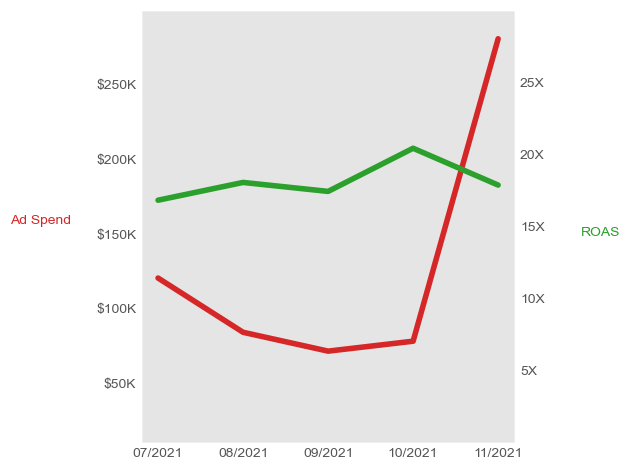

In [478]:
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import FuncFormatter

style.use('ggplot')

fig, ax1 = plt.subplots()

color = 'tab:red'
#ax1.set_xlabel('Month',labelpad=25)
ax1.set_ylabel('Ad Spend',color=color,rotation=0,labelpad=40)
ax1.plot(monthly["Date"], monthly["Cost"],color=color)
ax1.tick_params(axis='y')
ax1.grid(visible=False)
ax1.set_ylim(10000,300000)
ax1.set_yticks([250000,200000,150000,100000,50000])

def thousands(x, pos):
    return "$"'%1.fK' % (x * 1e-3)
formatter = FuncFormatter(thousands)
ax1.yaxis.set_major_formatter(formatter)

ax2 = ax1.twinx()

color = 'tab:green'
ax2.set_ylabel('ROAS',color=color,rotation=0,labelpad=40)
ax2.plot(monthly["Date"], monthly["ROAS"],color=color)
ax2.tick_params(axis='y')
ax2.grid(visible=False)
ax2.set_ylim(0,30)
ax2.set_yticks([25,20,15,10,5])

def xroas(x, pos):
    return (str(x)+""+"X")
formatter = FuncFormatter(xroas)
ax2.yaxis.set_major_formatter(formatter)

fig.tight_layout()
plt.show()

The peak in ROAS for October corresponds to the monthly performance roll-up table we generated earlier.

Overall we see higher costs during competitive months. November has the highest cost owing to Black Friday/Cyber Monday, while July has the second highest cost owing to the 4th of July holidays. For Cyber Monday, though ROAS begins to decrease after a certain volume of Ad Spend, note that's it is still quite high at around 17.9X.

<h3>Desktop Vs. Mobile<h3>

Let's see performance for desktop vs. mobile

In [521]:
mob_bool = media["Ad Group"].str.contains("Mob")==True
media["Device"] = np.where(mob_bool,"mobile","desktop")

device = media.groupby(["Device"],as_index=False,group_keys=True).agg(agg_func)

device["CTR"] = round(100*device["Clicks"]/device["Impressions"],1)
device["CPC Clicks"] = round(device["Cost"]/device["Clicks"],2)
device["CR"] = round(100*device["Conversions"]/device["Clicks"],1)
device["CPC Conv."] = round(device["Cost"]/device["Conversions"],2)
device["ROAS"] = round((device["Sale Amount"]-device["Cost"])/device["Cost"],1)

print(t(device[["Device", "ROAS", "CR", "CPC Conv.","CTR", "CPC Clicks", "Conversions","Sale Amount","Cost"]],headers="keys",floatfmt=",.2f"))

    Device      ROAS     CR    CPC Conv.    CTR    CPC Clicks    Conversions    Sale Amount    Cost
--  --------  ------  -----  -----------  -----  ------------  -------------  -------------  ------
 0  desktop    18.40  18.00         6.80  31.00          1.22          42190   5,575,436.43  286841
 1  mobile     17.60   7.80         6.48  36.00          0.51          53806   6,473,637.88  348531


Desktop ads delivered a 2.3X higher conversion rate along with a slightly higher ROAS than mobile at similar Cost Per Conversion. <br>

Mobile delivered higher Conversion and Sale volumes, but this is because more ad spend was put towards mobile campaigns. This is probably because mobile in general might have a higher CTR combined with a more cost-efficient CPC as we can see in the table above. 

Based on the results above, it might make sense to weight spend towards mobile & desktop devices more equally in future campaigns.

<h3>Top Ad Groups<h3>

Top 3 Ad Groups by ROAS:

In [524]:
total = media.groupby(["Ad Group"],as_index=False,group_keys=True).agg(agg_func).reset_index()
total["CTR"] = round(100*total["Clicks"]/total["Impressions"],1)
total["CPC"] = round(total["Cost"]/total["Clicks"],2)
total["CR"] = round(100*total["Conversions"]/total["Clicks"],1)
total["Cost per Conversion"] = round(total["Cost"]/total["Conversions"],2)
total["ROAS"] = round((total["Sale Amount"]-total["Cost"])/total["Cost"],1)

table = total[["Ad Group","ROAS","CR","Conversions","Cost per Conversion","CPC"]].sort_values("ROAS",ascending=False).head(4).reset_index(drop=True)
print(t(table,headers="keys"))

    Ad Group                                           ROAS    CR    Conversions    Cost per Conversion    CPC
--  -----------------------------------------------  ------  ----  -------------  ---------------------  -----
 0  Shop - Exact - Desk - Black Friday/Cyber Monday   298.6  29.2              7                   0.43   0.12
 1  Shop - Exact - Mob - Black Friday/Cyber Monday     73.3   9               24                   1.83   0.17
 2  Shop - Phrase - Desk - Free Shipping               48.5   7.9              3                   5.67   0.45
 3  Shop - Phrase - Mob - Competitor                   41.3  13               10                   4.1    0.53


Top 3 Ad Groups by Cost per Conversion:

In [523]:
table = total[["Ad Group","Cost per Conversion","Conversions","CR","CPC","ROAS"]].sort_values("Cost per Conversion",ascending=True).head(4).reset_index(drop=True)
print(t(table,headers="keys"))

    Ad Group                                           Cost per Conversion    Conversions    CR    CPC    ROAS
--  -----------------------------------------------  ---------------------  -------------  ----  -----  ------
 0  Shop - Exact - Desk - Black Friday/Cyber Monday                   0.43              7  29.2   0.12   298.6
 1  Shop - Exact - Mob - Black Friday/Cyber Monday                    1.83             24   9     0.17    73.3
 2  Shop - Exact - Desk - Free Shipping                               2.6             139  15.4   0.4     23.8
 3  Shop - Exact - Mob - Free Shipping                                3.17            105   6.8   0.21     9.7


Top performing Ad Groups in terms of ROAS and Cost per Conversion were the Black Friday/Cyber Monday campaigns, which is to be expected given that it's a key consumer event. Additionally, the Desktop version of the Cyber Monday campaign outperformed the mobile, which is consistent with the Desktop vs. Mobile analysis we did earlier.

However, the Cyber Monday campaigns drove few conversions (31 in total), indicating that those few purchases must have had a very high average order value. This would also explain why despite having a high ROAS for Cyber Monday ad group the average peak ROAS doesn't occur in November, the month when the event occurs. It's because this is a competitive month with most highest Cost per Conversion. 

<h3>Conclusion<h3>

With an 18X Return on Ad Spend the campaign appears to have been a success, however this analysis doesn't take into account revenue after the marketing retainer & other associated costs, so further analysis is required to determine whether the campaign generated a true profit.

Desktop appears to have performed slightly better than mobile with a 2.3X higher conversion rate and a very slight 4.5% higher ROAS. Mobile however was more cost-efficient with a 58% lower Cost per Click and slight 5% lower Cost per Conversion. Ad Spend for mobile was 20% higher: in future campaign weighting the spend more equally between desktop and mobile could be considered, but more research would need to be done first regarding attribution. That is, whether users who are seeing the ad on mobile are later ordering on desktop. 